In [1]:
import pandas as pd
import numpy as np
from fitter import fit, plot_data_together

# SEIR Absolute

In [11]:
import math

ITALY_POPULATION = 60461826
N=ITALY_POPULATION

params = [
    np.logspace(1, 2.5, 10),  # tau
    np.logspace(-4, 0, 8), # beta1
    np.logspace(-1, 1, 8), # beta2
    np.logspace(-7, -5, 8), # mu
    [1/14], # k
    [0.2, 0.3], # gamma
    [0.005, 0.01], # mu1
    np.logspace(-5, 0, 5), # delta
    np.logspace(-5, -2, 10), # alpha
    np.logspace(-1, 1, 8), # eta
]
def func_getter(tau, beta1, beta2, mu, k, gamma, mu1, delta, alpha, eta):
    # Если набор параметров невалиден, можно просто вернуть None, тогда такой набор будет пропущен
    
    initial_conditions = np.zeros(4)
    initial_conditions[0] = 0
    initial_conditions[1] = 150
    initial_conditions[2] = 3
    initial_conditions[3] = 0
    initial_conditions[0] = N - initial_conditions.sum()
    
    def ode_system(y,t): 
        # Функция с системой НЕ ПРИНИМАЕТ дополнительные параметры,
        # Но они автоматически "подсасываются" из-за вложенности в func_getter
        dy=[0,0,0,0]
        
        S, E, I, R = y
        
        dy[0] = tau - (mu + alpha)*S - (beta1*E + beta2*I) * S
        dy[0] /= N
        dy[1] = (beta1*E + beta2*I) * S - (k + mu + gamma) * E
        dy[1] /= N
        dy[2] = k*E - (mu + mu1 + delta + eta) * I
        dy[3] = delta * I - mu * R
        
        return dy
    
    return ode_system, initial_conditions

# Наши метрики: infected, recovered, dead
def solution_to_IRD(solution):
    infected = solution[:, 2]
    recovered = solution[:, 3]
    return infected, recovered

data = pd.read_csv('italy.csv')
data = data[9:]  # инфекции появляются только на десятый день
data['Заражений'] -= (data['Выздоровлений'] + data['Смертей'])
data = data[:40]
true_ird = (
    data['Заражений'],
    data['Выздоровлений'],
)
time_points = np.arange(true_ird[0].shape[0])

In [12]:
train_loss, val_loss, best_solution, best_params = fit(
    func_getter,
    time_points,
    params,
    solution_to_IRD,
    true_ird,
    val_samples=0.2,
    max_progress_level=3,
)
print(round(train_loss*1000, 4), round(val_loss*1000, 4), best_params)

KeyboardInterrupt: 

In [ ]:
plot_data_together(
    time_points, solution_to_IRD(best_solution), true_ird, N/5000, 
    labels=["Infected", "Recovered"],
    log_lower_bound=1e-8
)


6288512912262.953 2002074642763789.2 (21.544346900318832, 0.07196856730011514, 5.17947467923121, 1e-05, 0.07142857142857142, 0.3, 0.01, 0.0031622776601683794, 0.01, 2.6826957952797246)


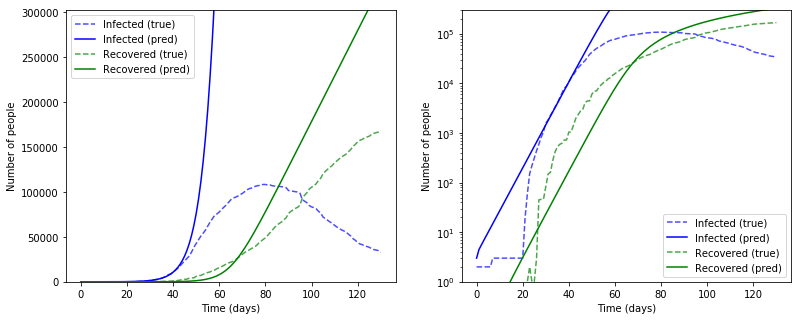

In [16]:
data = pd.read_csv('italy.csv')
data = data[9:]  # инфекции появляются только на десятый день
data['Заражений'] -= (data['Выздоровлений'] + data['Смертей'])
data = data[:140]
true_ird = (
    data['Заражений'],
    data['Выздоровлений'],
)
time_points = np.arange(true_ird[0].shape[0])
train_loss, val_loss, best_solution, _ = fit(
    func_getter,
    time_points,
    [[x] for x in best_params],
    solution_to_IRD,
    true_ird,
    val_samples=70,
    max_progress_level=3,
)
print(round(train_loss*1000, 4), round(val_loss*1000, 4), best_params)
plot_data_together(
    time_points, solution_to_IRD(best_solution), true_ird, N/200, 
    labels=["Infected", "Recovered"],
    log_lower_bound=1e0
)